###### versión 1.3.0 - 18.5.19
> Hergenreder, L. e Irigoyen, M. (2019). Generación de una herramienta de procesamiento de registros de ADV en lenguaje Python. Informe LHA-378-2019 Laboratorio de Hidráulica, Instituto Nacional del Agua, Argentina.

<img align="right" width="180" height="87" src="images/INALH_logo.png"> 
# INA-ADV

El presente es un documento interactivo con análisis básicos aplicados a señales de velocidad de flujos turbulentos obtenidas a través de un ADV Sontek 16MHz o un Nortek Vectrino II. Incluye:

1. Filtrado de valores anómalos a través del método Phase Space Thresholding (Goring y Nikora, 2002 modificado por Wahl 2003).
1. Evaluación de la calidad de la señal.
1. Extracción de ruido Doppler mediante el Análisis Espectral (Voulgaris y Trowbridge, 1998).
1. Cálculo de estadísticos corregidos por ruido Doppler.
1. Evaluación del tiempo óptimo de medicion a través del método Bootstrap (García et al., 2006).

Los procedimientos presentados deben aplicarse a archivos de extensión _*.Vf_ producidos por el software _WinADV_, si empleó el MicroADV Sontek o _*.mat_ en el caso de haber realizado las mediciones con un equipo Nortek Vectrino II.

## 1. Importación de librerías
---

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import scipy.stats as stats
from statsmodels.tsa.stattools import acf
import math

%matplotlib inline

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 2. Carga de series
---
Importación de los archivos de extensión _*.Vf_, o _*.mat_ según corresponda a mediciones de un equipo Sontek Micro ADV o Nortek Vectrino Profiler

### 2.1. Definición de la función *importar* y subfunciones
A continuación se define la función de importación *importar*, que emplea a las subfunciones *importarvectrino* o *importarsontek* dependiendo del equipo utilizado.

In [3]:
def importarvectrino(ruta,archivo,bin):
    data = sio.loadmat(ruta+'/'+archivo)
    #list(data.keys()) # variables dentro de data
    #data['Data\x00\x00\x00\x00'].dtype # variables dentro de data.'Data\x00\x00\x00\x00'
    #############
    # Serie de tiempo
    time = np.copy(data['Data\x00\x00\x00\x00'][0,0]['Profiles_TimeStamp'])
    #############
    # Extracción de las series correspondientes a todos los bins
    ## Velocidades
    Vx_raw = np.copy(data['Data\x00\x00\x00\x00'][0,0]['Profiles_VelX'][:,bin]) # samples x nº de bins
    Vy_raw = np.copy(data['Data\x00\x00\x00\x00'][0,0]['Profiles_VelY'][:,bin])
    Vz1_raw= np.copy(data['Data\x00\x00\x00\x00'][0,0]['Profiles_VelZ1'][:,bin])
    Vz2_raw = np.copy(data['Data\x00\x00\x00\x00'][0,0]['Profiles_VelZ2'][:,bin])
    # Pasaje a cm/s
    Vx_raw = 10 * Vx_raw
    Vy_raw = 10 * Vy_raw
    Vz1_raw = 10 * Vz1_raw
    Vz2_raw = 10 * Vz2_raw
    #############
    # Correlación media
    Cor_med = np.nanmean(np.array([data['Data\x00\x00\x00\x00'][0,0]['Profiles_CorBeam1'][:,bin],
                    data['Data\x00\x00\x00\x00'][0,0]['Profiles_CorBeam2'][:,bin],
                    data['Data\x00\x00\x00\x00'][0,0]['Profiles_CorBeam3'][:,bin],
                    data['Data\x00\x00\x00\x00'][0,0]['Profiles_CorBeam4'][:,bin]]),0) # samples x 1
    #############
    # SNR media
    SNR_med = np.nanmean(np.array([data['Data\x00\x00\x00\x00'][0,0]['Profiles_SNRBeam1'][:,bin],
                    data['Data\x00\x00\x00\x00'][0,0]['Profiles_SNRBeam2'][:,bin],
                    data['Data\x00\x00\x00\x00'][0,0]['Profiles_SNRBeam3'][:,bin],
                    data['Data\x00\x00\x00\x00'][0,0]['Profiles_SNRBeam4'][:,bin]]),0) # samples x 1
    return time,Vx_raw,Vy_raw,Vz1_raw,Cor_med,SNR_med

In [4]:
def importarsontek(ruta,archivo):
    data = np.genfromtxt(path+'/'+file, delimiter=";", skip_header=9)
    data[data==-99]=np.nan
    # Serie de tiempo
    time  = np.copy(data[:,0])
    #############
    # Velocidades
    Vx_raw = np.copy(data[:,3])
    Vy_raw = np.copy(data[:,4])
    Vz_raw = np.copy(data[:,5])
    #############
    # Correlación media para todos los beams
    Cor_med = np.copy(data[:,15])
    #############
    # Señal ruido (SNR) media para todos los beams
    SNR_med = np.copy(data[:,16])
    return time,Vx_raw,Vy_raw,Vz_raw,Cor_med,SNR_med

In [5]:
def importar(ruta,archivo,stkontk,bin):
    if stkontk == 1:
        time,Vx_raw,Vy_raw,Vz_raw,Cor_med,SNR_med = importarsontek(ruta,archivo)
    else:
        time,Vx_raw,Vy_raw,Vz_raw,Cor_med,SNR_med = importarvectrino(ruta,archivo,bin)
    return time,Vx_raw,Vy_raw,Vz_raw,Cor_med,SNR_med

### 2.2. Importación de archivos
---
A continuación se ejecutan las funciones definidas anteriormente. Modificar las variables *path*, *file* y *equipo*, con la ruta, nombre y tipo de equipo correspondiente al archivo a procesar. En el caso de haber empleado un Nortek Vectrino II, especificar el bin a analizar modificando *bininteres*; en caso contrario el valor no producirá ningún efecto.

In [6]:
path = 'datasets'
file = 'nortek.mat'
bininteres = 11
equipo = 2 # Cambiar según equipo utilizado (1:sontek, 2:nortek)

In [7]:
time,Vx_raw,Vy_raw,Vz_raw,Cor_med,SNR_med = importar(path,file,equipo,bininteres)

Cálculo de la frecuencia de muestreo $f_s$.

In [8]:
fs = 1//(time[1]-time[0])

### 2.3. Gráficación de las series importadas
A continuación se grafican las series de velocidad sin procesamientos.

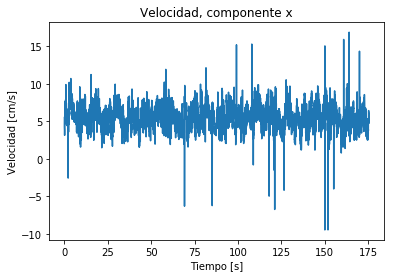

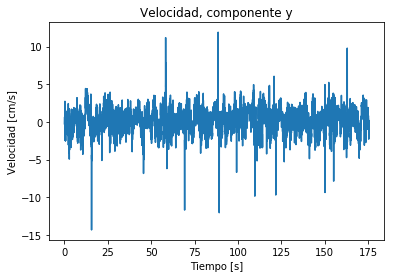

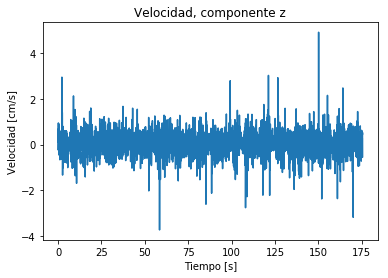

In [8]:
plt.figure(1)
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [cm/s]')
plt.title('Velocidad, componente x')
plt.plot(time,Vx_raw)

plt.figure(2)
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [cm/s]')
plt.title('Velocidad, componente y')
plt.plot(time,Vy_raw)

plt.figure(3)
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [cm/s]')
plt.title('Velocidad, componente z')
plt.plot(time,Vz_raw)

## 3. Filtrado de valores anómalos
---
Las señales de velocidad del flujo pueden presentar en algunos casos, valores extremos anómalos (denominados “spikes” en inglés), originados por distintas razones como por ejemplo la presencia de velocidades de flujo que exceden al rango de velocidad seleccionado en la configuración del instrumento, por contaminación de pulsos previos reflejados desde contornos de geometrías complejas, por falta de partículas trazadoras en el agua, cuando los niveles de turbulencia son muy elevados, etc. Estos valores anómalos presentes en la señal generan errores (sesgo) en la determinación de los parámetros de la turbulencia que se estiman sobre la base de estas series (García et al. 2016). La técnica de detección más difundida es la denominada Phase Space Thresholding (Goring y Nikora, 2002) modificada por Wahl (2003).

### 3.1. Definición de la función _spikeGoringNikora_ y subfunciones
A continuación se define la función *spikeGoringNikora*. La misma identifica y reemplaza los valores anómalos según el procedimiento ideado por Goring y Nikora (2002) y moficidado por Wahl (2003). La función, basada en el código [MITT](https://github.com/macvicab/MITT) (MacVicar et al., 2014),  requiere ingresar una serie de velocidad a la cual se le haya sustraído la mediana.

El método requiere identificar los puntos exteriores a una elipse definida en un espacio de Poincaré por el denominado criterio Universal (Goring y Nikora, 2002). Esto se realiza en el presente código mediante la subfunción *inellipse*. Posterioremente, se genra una nueva serie de velocidad en las que los puntos individualizados son reemplazados por una interpolación lineal entre valores aledaños. Dicha tarea se ejecuta a través de la subfunción *lininterp*. Adicionalmente se produce una segunda señal en la que los valores anómalos son reemplazados por el marcador *NaN*.

In [9]:
def inellipse(xDat, yDat, xEllipse, yEllipse):
    yes = np.zeros(xDat.shape[0])==0
    angEllipse = np.arctan2(yEllipse,xEllipse)
    rEllipse = np.sqrt(xEllipse**2 + yEllipse**2)
    if any(angEllipse>0):
        angEllipse = angEllipse[:-1]
        rEllipse = rEllipse[:-1]
        sortIDX = [b[0] for b in sorted(enumerate(angEllipse),key=lambda i:i[1])]
        angEllipse = angEllipse[sortIDX]
        rEllipse = rEllipse[sortIDX]
        angEllipse = np.hstack((angEllipse[-1]-2*np.pi,angEllipse))
        rEllipse = np.hstack((rEllipse[-1],rEllipse))
        ravgEllipse = rEllipse[0:-1]+np.diff(rEllipse)/2
        ##
        # Determine in or out status of the point
        angDat=np.arctan2(yDat, xDat)
        rDat = np.sqrt(xDat**2 + yDat**2)
        angIDX = np.digitize(angDat,angEllipse)
        nogoo = np.argwhere(angIDX == len(angEllipse)) | (angIDX == 0)
        nogoo = nogoo[:,1]
        angIDX[nogoo] = 1
        angmem = np.unique(angIDX)
        natot = len(angmem)
        for na in range(0,natot):
            goo = angIDX == angmem[na]
            yes[goo] = rDat[goo]<=ravgEllipse[angmem[na]-1]
        return yes

In [10]:
def lininterp(a):
    b = np.copy(a)
    ok = ~np.isnan(b)
    xp = ok.ravel().nonzero()[0]
    fp = b[~np.isnan(b)]
    x  = np.isnan(b).ravel().nonzero()[0]
    b[np.isnan(b)] = np.interp(x, xp, fp)
    return b

In [11]:
def spikeGoringNikora(velnomedian,UniMult):
    counterlim = 4 # Número máximo de loops de detección de spikes
    
    nttot = velnomedian.shape[0]
    spikelim = np.max([5,np.floor(nttot*0.001)]) # Fija el número mínimo de spikes detectados para iniciar el loop luego del reemplazo
    UniThresh = UniMult*(2*np.log(nttot))**0.5 # Cálculo del límite Universal
    sig=np.arange(0, 2 * np.pi + 2*np.pi/144, 2*np.pi/144)
    
    # Preparación de la serie de tiempo de velocidad para el análisis
    vel = np.zeros([nttot,3])
    yes = np.copy(vel)
    vel[:,0] = np.copy(velnomedian)
    veldespike = np.copy(velnomedian) # Vector con spikes reemplazados
    veldespikenan = np.copy(velnomedian) # Vector con NaN en los spikes
    
    # Loop para la remoción de spikes
    spike = 1
    counter = 0
    stdvel = np.zeros(3)
    theta = np.zeros(3)
    
    while spike:
        # paso 1: cálculo de las derivadas
        vel[1:-1,1] = (vel[2:,0]-vel[0:-2,0])/2
        vel[2:-2,2] = (vel[3:-1,1]-vel[1:-3,1])/2
        
        # paso 2 - cálculo de los desvíos estándar de las tres variables
        for nv in range(3):
            stdvel[nv] = 1.483*np.median(np.abs(vel[:,nv]-np.median(vel[:,nv])))
        # paso 2b - cálculo de los máximos teóricos utilizando el criterio Universal
        maxvel = stdvel*UniThresh
        
        # paso 3 - cálculo del ángulo de rotación del eje principal (veldd vs vel)
        theta[0:1] = 0
        theta[2] = np.arctan(np.dot(vel[:,0],vel[:,2])/np.sum(vel[:,0]**2))
        
        # paso 4 - cálculo de la elipse para cada par de variables
        # xa and ya specify the order of the x and y axis variables respectively
        xa = [0,1,0]
        ya = [1,2,2]
        for fg in range(3):
            a = xa[fg]
            b = ya[fg]
            r = ((maxvel[a]**2*maxvel[b]**2)/(maxvel[a]**2*(np.sin(sig))**2 +
                  maxvel[b]**2*(np.cos(sig))**2))**0.5
            xi = r * np.cos(sig) # conversión polar a cartesiana
            yi = r * np.sin(sig)
            x = xi*np.cos(theta[fg])-yi*np.sin(theta[fg])
            y = yi*np.cos(theta[fg])+xi*np.sin(theta[fg])
            yes[:,fg] = ~inellipse(vel[:,a],vel[:,b],x,y)
        spikeyes = (yes[:,0]==1) | (yes[:,1]==1) | (yes[:,2]==1)
        veldespikenan[spikeyes] = np.nan
        veldespike = lininterp(veldespikenan)
        spike = ((spikeyes==True).sum()>spikelim) & (counter < counterlim) # Para continuar reemplazo: más de 5 spikes detectados. Cantidad máxima de loops: counterlim
        counter = counter+1;
    return veldespikenan, veldespike

### 3.2. Aplicación del método *Phase Space Thresholding*
A continuación se aplica el método presentado. Previamente se sustrae la mediana de los registros de velocidades, para ser adicionada luego del filtrado. Notar que se obtienen series de velocidades filtradas (con reemplazos de los valores anómalos) y series que presentan el indicador *NaN* en los lugares en los que se detectaran valores anómalos.

In [12]:
# Extracción de la mediana
vxnomediana = Vx_raw - np.nanmedian(Vx_raw)
vynomediana = Vy_raw - np.nanmedian(Vy_raw)
vznomediana = Vz_raw - np.nanmedian(Vz_raw)

# Aplicación del método
#Vx_gn con NaN en spikes, Vx_int con valores interpolados, idem otras componentes
[Vx_gn,Vx_int] = spikeGoringNikora(vxnomediana,1) 
[Vy_gn,Vy_int] = spikeGoringNikora(vynomediana,1)
[Vz_gn,Vz_int] = spikeGoringNikora(vznomediana,1)

# Adición de la mediana
Vx_gn[np.isnan(Vx_gn)==False] += np.median(Vx_raw) 
Vy_gn[np.isnan(Vx_gn)==False] += np.median(Vy_raw)
Vz_gn[np.isnan(Vx_gn)==False] += np.median(Vz_raw)
Vx_int += np.median(Vx_raw)
Vy_int += np.median(Vy_raw)
Vz_int += np.median(Vz_raw)

### 3.3. Graficación de las series filtradas

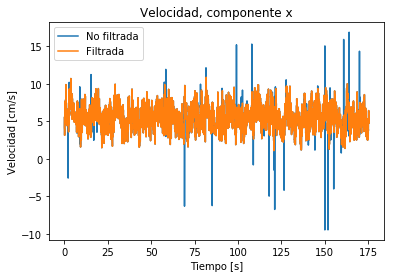

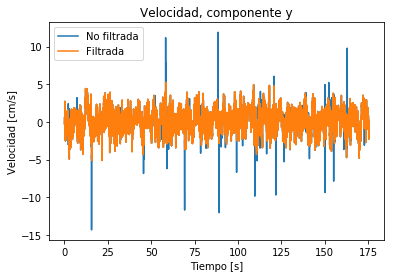

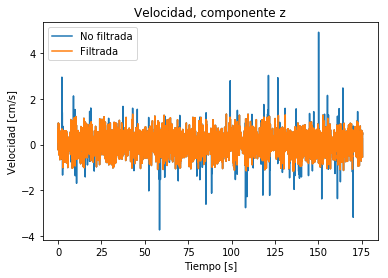

In [13]:
plt.figure(1)
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [cm/s]')
plt.title('Velocidad, componente x')
plt.plot(time,Vx_raw)
plt.plot(time,Vx_int)
plt.legend(['No filtrada','Filtrada'])

plt.figure(2)
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [cm/s]')
plt.title('Velocidad, componente y')
plt.plot(time,Vy_raw)
plt.plot(time,Vy_int)
plt.legend(['No filtrada','Filtrada'])

plt.figure(3)
plt.xlabel('Tiempo [s]')
plt.ylabel('Velocidad [cm/s]')
plt.title('Velocidad, componente z')
plt.plot(time,Vz_raw)
plt.plot(time,Vz_int)
plt.legend(['No filtrada','Filtrada'])

## 4. Evaluación de la calidad de la señal
---
### 4.1. Señal ruido (SNR)
La $SNR$ relaciona la amplitud de la señal acústica recibida y el ruido ambiente. Es un indicador de la cantidad de partículas presentes en el agua (sedimentos, organismos pequeños, burbujas) que reflejarán los pulsos acústicos. **Valores menores a 15 db indicarían la presencia de pocas particulas, y la necesidad de adicionarlas.** (García, et al.2016)

In [14]:
display('SNR media (dB): '+ str(np.nanmean(SNR_med)))
display('SNR varianza (dB^2): '+ str(np.nanvar(SNR_med)))

'SNR media (dB): 39.6575'

'SNR varianza (dB^2): 34.7189'

### 4.2. Correlación
**Generalmente, se requiere un parámetro de correlación mayor al 70% para obtener una buena representación del flujo.** (García )

In [15]:
display('Correlación media (%): '+ str(np.nanmean(Cor_med)))
display('Correlación varianza (%): '+ str(np.nanvar(Cor_med)))

'Correlación media (%): 91.9277'

'Correlación varianza (%): 32.6937'

### 4.3. Cantidad de valores anómalos filtrados
La cantidad de valores anómalos filtrados debe ser reducida, para garantizar que la señal de velocidad represente al campo de velocidades.

In [16]:
display('Valores filtrados Vx (%): '+str(100*np.count_nonzero(np.isnan(Vx_gn))/len(Vx_gn)))
display('Valores filtrados Vy (%): '+str(100*np.count_nonzero(np.isnan(Vy_gn))/len(Vy_gn)))
display('Valores filtrados Vz (%): '+str(100*np.count_nonzero(np.isnan(Vz_gn))/len(Vz_gn)))

'Valores filtrados Vx (%): 2.4863138686131387'

'Valores filtrados Vy (%): 2.281021897810219'

'Valores filtrados Vz (%): 2.6231751824817517'

## 5. Extracción del ruido Doppler
---
Nikora y Goring (1998) señalaron que la principal fuente de ruido en las mediciones que se realizan con velocímetros acústico doppler es el ruido Doppler. García et al. (2005) analizaron la importancia relativa de la energía del ruido Doppler con respecto al total de la energía turbulenta capturada con los ADV, señalando que cuando el impacto del ruido es alto se
requieren correcciones a los parámetros de la turbulencia que se estimen. El ruido Doppler tiene las características del ruido blanco (Nikora y Goring 1998) con una distribución de probabilidad Gaussiana, esto es media cero y varianza finita (Nikora y Goring 1998), así como también un espectro de potencia plano (Anderson y Lohrmann 1995), es decir afecta de igual modo a todas las componentes de frecuencias de la señal ( espectro de potencia constante sobre el rango de frecuencias muestreadas) lo cual indica la presencia de ruido sin correlación. La presencia de ruido blanco en las señales de velocidad medidas con ADV no afecta el cálculo de los valores medios (Nikora y Goring, 1998; Voulgaris y Trowbridge 1998) ni el de las Tensiones de Reynolds (McLelland y Nicholas, 2000), mientras que las estimaciones de la energía cinética turbulenta se encuentra sesgada hacia valores más altos (Nikora y Goring 1998). Puesto que el ruido blanco produce falta de correlación en la señal la función de autocorrelación reduce su valor a cero más rápido que cuando se verifica presencia de ruido, al tiempo que el espectro de potencia resulta sesgado a valores altos (Nikora y Goring 1998).

Para señales de relativa baja energía, el ruido blanco puede detectarse como un aplanamiento del espectro próximo a la frecuencia de Nyquist (*fs/2*) (García 2005). En esos casos Nikora y Goring (1998) sugieren que el espectro de dicho ruido se puede representar por una línea horizontal recta cuyas ordenadas son igual al promedio de las ordenadas espectrales del ruido. Esta técnica fue llamada “Análisis espectral” por Voulgaris y Trowbridge (1998), quienes proponen calcular la energía asociada al ruido a partir del nivel de energía detectado en la cola del espectro, en un rango de frecuencias tal que garantice 10 estimaciones para el cálculo del promedio estadístico.

### 5.1. Determinación del nivel de ruido
A continuación se aplica el "Análisis espectral" (Voulgaris y Trowbridge, 1998) para la extracción del ruido Doppler del espectro de energía de la señal de velocidad. Se adopta el rango $[fs/2-1Hz,fs/2]$ para el cálculo del nivel de energía del ruido. **Debe verificarse visualmente que dicho nivel se corresponda con un aplanamiento en el espectro de la señal no filtrada, y que el rango contenga por lo menos 10 valores.**

In [17]:
def noise (a,nfft):
    (psd, freq)=mlab.psd(a-np.mean(a), detrend=mlab.detrend_none, noverlap=nfft//2, NFFT=nfft, Fs=fs,window=np.hamming(nfft),pad_to=nfft,sides='onesided',scale_by_freq=True)
    dopplernoise = np.mean(psd[len([f for f in freq if f <= 0.5*fs-1]):])
    display('Cantidad de valores en el rango [fs/2-1Hz, fs/2]: '+str(len([f for f in freq if f <= 0.5*fs-1])))
    return psd, freq, dopplernoise

In [18]:
psdx_unf,fx,noisex = noise(Vx_int,1024)
psdy_unf,fy,noisey = noise(Vy_int,1024)
psdz_unf,fz,noisez = noise(Vz_int,1024)

display('Ruido Doppler, componente x (cm2/s): ' + str(noisex))
display('Ruido Doppler, componente y (cm2/s): ' + str(noisey))
display('Ruido Doppler, componente z (cm2/s): ' + str(noisez))

'Cantidad de valores en el rango [fs/2-1Hz, fs/2]: 492'

'Cantidad de valores en el rango [fs/2-1Hz, fs/2]: 492'

'Cantidad de valores en el rango [fs/2-1Hz, fs/2]: 492'

'Ruido Doppler, componente x (cm2/s): 0.0114362708085'

'Ruido Doppler, componente y (cm2/s): 0.0129342597419'

'Ruido Doppler, componente z (cm2/s): 0.00223043572277'

### 5.2. Verificación del nivel de ruido
A continuación se grafican los espectros de energía de las componentes de la velocidad, con el objetivo de verificar visualmente el valor de densidad espectral de potencia obtenido analíticamente en las celdas anteriores.

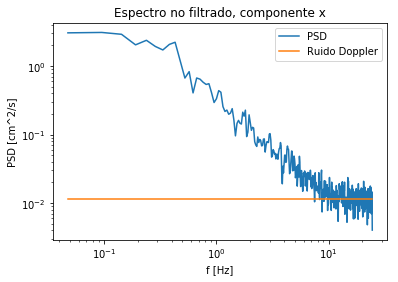

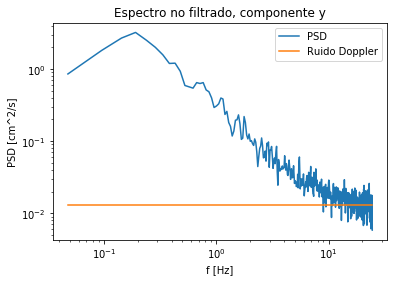

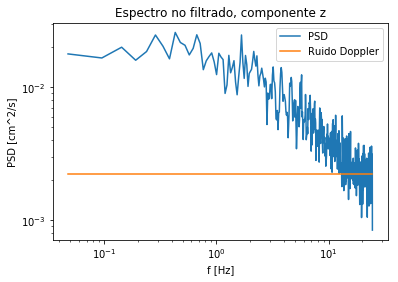

In [20]:
# Componente x
plt.figure(1)
plt.title('Espectro no filtrado, componente x')
plt.ylabel('PSD [cm^2/s]')
plt.xlabel('f [Hz]')
plt.loglog(fx,psdx_unf)
plt.loglog(fx,noisex*np.ones(len(fx)))
plt.legend(['PSD','Ruido Doppler'])

# Componente y
plt.figure(2)
plt.title('Espectro no filtrado, componente y')
plt.ylabel('PSD [cm^2/s]')
plt.xlabel('f [Hz]')
plt.loglog(fy,psdy_unf)
plt.loglog(fy,noisey*np.ones(len(fy)))
plt.legend(['PSD','Ruido Doppler'])

# Componente z
plt.figure(3)
plt.title('Espectro no filtrado, componente z')
plt.ylabel('PSD [cm^2/s]')
plt.xlabel('f [Hz]')
plt.loglog(fz,psdz_unf)
plt.loglog(fz,noisez*np.ones(len(fz)))
plt.legend(['PSD','Ruido Doppler'])

### 5.3. Cálculo de PSD filtrada
A continuación se corrige la densidad espectral de potencia de las componentes de la velocidad mediante la sustracción del bloque correspondiente a ruido.

In [21]:
psdx = psdx_unf - noisex*np.ones(len(psdx_unf))
psdy = psdy_unf - noisey*np.ones(len(psdy_unf))
psdz = psdz_unf - noisez*np.ones(len(psdz_unf))

## 6. Cálculo de estadísticos y cantidades turbulentas
---
A continuación se realiza el cálculo de estadísticos y cantidades turbulentas a partir de las señales de velocidad corregidas pod ruido Doppler y valores anómalos.
### 6.1. Valor medio

In [22]:
Vx = np.nanmean(Vx_int)
Vy = np.nanmean(Vy_int)
Vz = np.nanmean(Vz_int)

display('Velocidad media dirección x (cm/s): '+str(Vx))
display('Velocidad media dirección y (cm/s): '+str(Vy))
display('Velocidad media dirección z (cm/s): '+str(Vz))

'Velocidad media dirección x (cm/s): 5.52991'

'Velocidad media dirección y (cm/s): 0.226683'

'Velocidad media dirección z (cm/s): 0.0815769'

### 6.2. Serie temporal de fluctuaciones

In [23]:
vx = Vx_int-np.nanmean(Vx_int)
vy = Vy_int-np.nanmean(Vy_int)
vz = Vz_int-np.nanmean(Vz_int)

### 6.3. Varianzas

In [24]:
# Sin corrección por ruido Doppler
varx_unc = np.nanvar(Vx_int)
vary_unc = np.nanvar(Vy_int)
varz_unc = np.nanvar(Vz_int)

display('Varianza no corregida por ruido Doppler, dirección x (cm2/s2): '+str(varx_unc))
display('Varianza no corregida por ruido Doppler, dirección y (cm2/s2): '+str(vary_unc))
display('Varianza no corregida por ruido Doppler, dirección z (cm2/s2): '+str(varz_unc))

'Varianza no corregida por ruido Doppler, dirección x (cm2/s2): 2.05508'

'Varianza no corregida por ruido Doppler, dirección y (cm2/s2): 1.87224'

'Varianza no corregida por ruido Doppler, dirección z (cm2/s2): 0.12739'

In [25]:
# Corregidas por ruido Doppler
# Serie temporal
uu = vx*vx
vv = vy*vy
ww = vz*vz

# Valores medios
varx = varx_unc - noisex*fs/2
vary = vary_unc - noisey*fs/2
varz = varz_unc - noisez*fs/2

display('Varianza corregida por ruido Doppler, dirección x (cm2/s2): '+str(varx))
display('Varianza corregida por ruido Doppler, dirección y (cm2/s2): '+str(vary))
display('Varianza corregida por ruido Doppler, dirección z (cm2/s2): '+str(varz))

'Varianza corregida por ruido Doppler, dirección x (cm2/s2): [ 1.77489448]'

'Varianza corregida por ruido Doppler, dirección y (cm2/s2): [ 1.55534935]'

'Varianza corregida por ruido Doppler, dirección z (cm2/s2): [ 0.07274464]'

### 6.4. Tensiones de Reynolds

In [26]:
# Serie temporal de tensiones de Reynolds
uv = vx*vy
uw = vx*vz
vw = vy*vz

# Tensiones de Reynolds medias
covaruv = np.mean(Vx_int*Vy_int)
covaruw = np.mean(Vx_int*Vz_int)
covarvw = np.mean(Vy_int*Vz_int)

display('Covarianza, direcciones xy (cm2/s2): ' + str(covaruv))
display('Covarianza, direcciones xz (cm2/s2): ' + str(covaruw))
display('Covarianza, direcciones yz (cm2/s2): ' + str(covarvw))

'Covarianza, direcciones xy (cm2/s2): 0.80791'

'Covarianza, direcciones xz (cm2/s2): 0.383491'

'Covarianza, direcciones yz (cm2/s2): -0.0169218'

### 6.5. Energía cinética turbulenta

In [27]:
# Serie temporal de energía cinética turbulenta
tke = 0.5*(uu + vv + ww)

# Energía cinética turbulenta media
TKE = 0.5*(varx+vary+varz)

display('Energía cinética turbulenta (cm2/s2): ' + str(TKE))

'Energía cinética turbulenta (cm2/s2): [ 1.70149422]'

### 6.6. Intensidad de turbulencia

In [28]:
Itx = np.sqrt(varx)/np.abs(Vx)
Ity = np.sqrt(vary)/np.abs(Vy)
Itz = np.sqrt(varz)/np.abs(Vz)
It = np.sqrt(1/3*(varx+vary+varz))/np.sqrt(Vx**2+Vy**2+Vz**2)

display('Intensidad de turbulencia, dirección x: ' + str(Itx))
display('Intensidad de turbulencia, dirección y: ' + str(Ity))
display('Intensidad de turbulencia, dirección z: ' + str(Itz))
display('Intensidad de turbulencia: ' + str(It))

'Intensidad de turbulencia, dirección x: [ 0.24091724]'

'Intensidad de turbulencia, dirección y: [ 5.50167179]'

'Intensidad de turbulencia, dirección z: [ 3.30623317]'

'Intensidad de turbulencia: [ 0.19241524]'

## 7. Determinación del tiempo óptimo de medición
---
Los tiempos de medición óptimos se determinan analizando la incertidumbre esperada en la estimación de los paramentos
turbulentos, sobre la base de series de velocidad de larga duración, las que a su vez serán sub-muestreadas con distintas duraciones. Para cada una de las sub-series conformadas se aplica la técnica de remuestreo MBB (moving block bootstrap) para estimar la incertidumbre de los siguientes parámetros:
1. Velocidades medias
2. Varianzas
3. Energía cinética turbulenta
4. Tensiones de Reynolds

En cada caso la técnica MBB se aplica con 1000 replicaciones. Sobre la base de los resultados proporcionados se calcularon los correspondientes coeficientes de variación, CV, definidos como la relación entre el error desvío estándar y el valor medio de cada parámetro.

### 7.1. Determinación del tamaño de bloque óptimo
La función *bopt* se emplea para determinar la longitud de bloque óptimo que será empleada en la aplicación de la técnica MBB. Esta longitud está basada en la escala de tiempo integral de la turbulencia y se determina para cada tiempo de medición bajo análisis.

#### Definición de la función *bopt*

In [29]:
def bopt(vx,Tm): # vx: señal de velocidad, Tm: tiempo de medición
    acfunc = acf(vx-np.mean(vx), nlags=len(vx), fft=False, unbiased=True) # Función autocorrelación
    zero_crossings = np.where(np.diff(np.sign(acfunc)))[0]
    Tx = np.trapz(acfunc[0:zero_crossings[0]],(1/fs)*range(zero_crossings[0])) # Escala de tiempo integral
    bop = 0.788 * Tx**(2/3) * Tm**(1/3)
    return bop

#### Aplicación de la función *bopt*
A continuación de aplica la función *bopt* para obtener un vector *bop* con las longitudes de tiempo óptimas para cada tiempo de medición considerado.

In [30]:
# Cálculo de los vectores tiempos de medición (Tm) y tamaños de bloque óptimos para distintos Tm
V = Vx_int # Señal de velocidad
Ttot = (1/fs)*(len(V)-1)/60 # Tiempo total de medición, en minutos
Tm = np.linspace(1,int(Ttot),20) # Tiempos de medición considerados para el análisis, en minutos
bop = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    bop[i] = bopt(vi,Tm[i])

### 7.2. Obtención del tiempo de medición óptimo
Para la obtención del tiempo de medición óptimo se analiza un registro extenso correspondiente a un parámetro de interés. Este registro se muestrea para diferentes duraciones o tiempos de medición. A cada una de estas sub-series se les aplica el método MBB, para obtener el coeficiente de variación de su media.

El método MBB es aplicado aquí a partir de la función *bootstrap*. El mismo crea, a partir de una sub-serie de duración *Tm*, *nboot* series temporales artificiales. Luego, es posible promediar cada una de ellas para obtener un conjunto de *nboot* valores medios correspondientes al tiempo *Tm*. A partir de esta nueva *serie de medias*, se pueden calcular el promedio y el desvío estandar y, consecuentemente, el coeficiente de variación.

La repetición de este procedimiento para diferentes tiempos de medición permite obtener una serie de coeficientes de variación de la media del parámetro de interés. El tiempo de medición óptimo será el valor mínimo que produzca que el coeficiente de variación sea menor que cierto valor deseado.

In [31]:
def bootstrap(v,Tblock,nboot):
    b = math.ceil(Tblock*fs) # Longitud de cada bloque
    nblock = int(len(v)/b) # Número de bloques en una serie artificial
    vc = np.zeros((len(v)-b+1,b)) # Variable con los N-b+1 posibles bloques de long. b
    #vartif = np.zeros((nboot,nblock*b)) # Variable con las nboot series artificiales de long. nblock*b
    vmean = np.zeros(nboot)
    for i in range(len(v)-b+1):
        vc[i,:] = np.copy(v[i:i+b])
    for j in range(nboot):
        d = vc[random.sample(list(range(vc.shape[0])),nblock),:] # Selección random de nblock bloques
        #vartif[j,:] = np.reshape(d,(1,d.shape[0]*d.shape[1])) # Ordenamiento de la matriz d
        vmean[j] = np.nanmean(d) # Serie de medias de las series artificiales de velocidad
    return np.mean(vmean), np.var(vmean)

### 7.3. Aplicación de la metodología a parámetros de interés
#### Velocidades medias

In [32]:
# Aplicación de MBB para distintas duraciones
V = Vx_int # Señal de larga duración a evaluar
vmean = np.zeros(len(Tm))
vvar = np.zeros(len(Tm))
cv = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    vmean[i],vvar[i] = bootstrap(vi,bop[i],1000)    
    cv[i] = np.sqrt(vvar[i])/np.absolute(vmean[i])

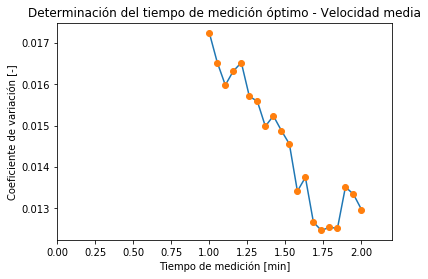

In [33]:
# Gráfico
plt.plot(Tm,cv)
plt.plot(Tm,cv,'o')
#plt.plot([0, Tm[-1]*1.1],cv[-1]*1.1*np.ones(2),'k--',linewidth=0.5)
#plt.plot([0, Tm[-1]*1.1],cv[-1]*0.9*np.ones(2),'k--',linewidth=0.5)
plt.xlim(0,Tm[-1]*1.1)
plt.title('Determinación del tiempo de medición óptimo - Velocidad media')
plt.xlabel('Tiempo de medición [min]')
plt.ylabel('Coeficiente de variación [-]')

#### Varianzas

In [34]:
# Aplicación de MBB para distintas duraciones
V = uu # Señal de larga duración a evaluar
vmean = np.zeros(len(Tm))
vvar = np.zeros(len(Tm))
cv = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    vmean[i],vvar[i] = bootstrap(vi,bop[i],1000)    
    cv[i] = np.sqrt(vvar[i])/np.absolute(vmean[i])

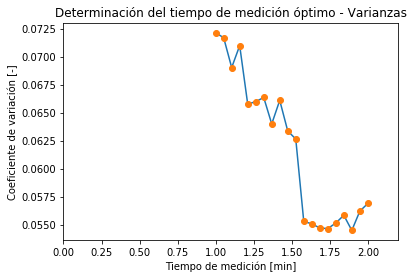

In [35]:
# Gráfico
plt.plot(Tm,cv)
plt.plot(Tm,cv,'o')
#plt.plot([0, Tm[-1]*1.1],cv[-1]*1.1*np.ones(2),'k--',linewidth=0.5)
#plt.plot([0, Tm[-1]*1.1],cv[-1]*0.9*np.ones(2),'k--',linewidth=0.5)
plt.xlim(0,Tm[-1]*1.1)
plt.title('Determinación del tiempo de medición óptimo - Varianzas')
plt.xlabel('Tiempo de medición [min]')
plt.ylabel('Coeficiente de variación [-]')

#### Energía cinética turbulenta

In [36]:
# Aplicación de MBB para distintas duraciones
V = tke # Señal de larga duración a evaluar
vmean = np.zeros(len(Tm))
vvar = np.zeros(len(Tm))
cv = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    vmean[i],vvar[i] = bootstrap(vi,bop[i],1000)    
    cv[i] = np.sqrt(vvar[i])/np.absolute(vmean[i])

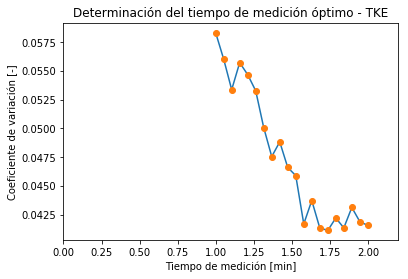

In [37]:
# Gráfico
plt.plot(Tm,cv)
plt.plot(Tm,cv,'o')
#plt.plot([0, Tm[-1]*1.1],cv[-1]*1.1*np.ones(2),'k--',linewidth=0.5)
#plt.plot([0, Tm[-1]*1.1],cv[-1]*0.9*np.ones(2),'k--',linewidth=0.5)
plt.xlim(0,Tm[-1]*1.1)
plt.title('Determinación del tiempo de medición óptimo - TKE')
plt.xlabel('Tiempo de medición [min]')
plt.ylabel('Coeficiente de variación [-]')

#### Tensiones de Reynolds

In [38]:
# Aplicación de MBB para distintas duraciones
V = uv # Señal de larga duración a evaluar
vmean = np.zeros(len(Tm))
vvar = np.zeros(len(Tm))
cv = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    vmean[i],vvar[i] = bootstrap(vi,bop[i],1000)    
    cv[i] = np.sqrt(vvar[i])/np.absolute(vmean[i])

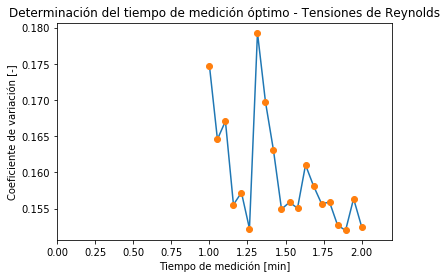

In [39]:
# Gráfico
plt.plot(Tm,cv)
plt.plot(Tm,cv,'o')
#plt.plot([0, Tm[-1]*1.1],cv[-1]*1.1*np.ones(2),'k--',linewidth=0.5)
#plt.plot([0, Tm[-1]*1.1],cv[-1]*0.9*np.ones(2),'k--',linewidth=0.5)
plt.xlim(0,Tm[-1]*1.1)
plt.title('Determinación del tiempo de medición óptimo - Tensiones de Reynolds')
plt.xlabel('Tiempo de medición [min]')
plt.ylabel('Coeficiente de variación [-]')

---

## 8. Referencias
* García C.M., Scacchi G., Herrero H.S., Díaz Lozada J.M., Pedocchi F., Niño Y. y García M.H. (2016). "Guía práctica para realizar mediciones de velocidad en flujos turbulentos con ADV. Versión 2016". Extraído de: Scacchi G. (2017) "Interacción entre el flujo turbulento y los procesos de erosión junto a estribos de puentes protegidos. Estudio experimental"

* MacVicar B., Dilling S., Lacey J. (2014) "Multi-instrument turbulence toolbox (MITT): Open-source MATLAB algorithms for the analysis of high-frequency flow velocity time series datasets". Computers & Geosciences, Volume 73, (12), pp 88-98.

* García, C. M., y Garcia, M. H. (2006). Characterization of flow turbulence in large-scale bubble-plume experiments. Experiments in Fluids, 41(1), 91-101. Ver García C.M. "Turbulence measurements using Accoustic Doppler Velocimeters", documento anexo al código TuDe (Turbulence Description) copia en papel disponible en el Programa de Hidráulica Fluvial.

* García C., Cantero M., Niño Y., and García M. (2005). “Turbulence measurements with Acoustic Doppler Velocimeters”. J.Hydr. Engrg. ASCE. 131, 1062-1073.

* García C., Jackson P., and García M. (2006). “Confidence intervals in the determination of turbulence parameters”. Experiment in Fluids. 40: 514 – 522.

* Wahl, T. L. (2003), Discussion of ‘‘Despiking Acoustic Doppler Velocimeter Data’’ by Derek G. Goring and Vladimir I. Nikora, Journal of Hydraulic Engineering, 129(6), 484-487

* Goring D., Nikora, V. (2002). "Despiking Acoustic Doppler Velocimeter Data". J. Hydr. Engrg. ASCE, Volume 128, (1), 117-126.

* McLelland S. and Nicholas A. (2000). "A new method for evaluating errors in high frequency ADV measurements". Hydrological Processes. 14, 351-366.

* Nikora V., and Goring D. (1998). "ADV measuremets of turbulence: Can we improve their interpretation?" J.Hydr. Engrg. ASCE. 124, 630-634.

* Voulgaris G., and Trowbridge J. (1998). "Evaluation of the acoustic Doppler velocimeter (ADV) for turbulence measurements". Journal of Atmospheric and Oceanic Technology. 15, 272-288.

---

Ignorar la siguiente celda, la misma ejecuta los estilos del documento.

In [1]:
from IPython.core.display import HTML
def css_styling(filepath):
    styles = open(filepath, 'r').read()
    return HTML(styles)
css_styling('styles/style.css')